In [1]:
import os

import pickle as pkl

import time

import numpy as np

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.cm as cm

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 20  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 28  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 28  # Font size of titlea

plt.rcParams['legend.fontsize'] = 20


2025-12-29 08:34:17.558605: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 08:34:18.091508: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-29 08:34:18.091563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-29 08:34:18.095397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-29 08:34:18.375328: I tensorflow/core/platform/cpu_feature_g

In [2]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
%run -i smc.py
%run -i block_smc.py
os.chdir("../")

# HMC

Unzip the folder HMC_replicates_reduced. We refer to Zenodo for the complete experiment.

In [16]:
parameters = {
	      "log_beta":np.log(np.array([0.2])),
	      "b_S":np.array([+0.5]),
              "b_I":np.array([+1.0]),
              "log_gamma":np.log(np.array([0.1])),
              "b_R":np.array([-0.5]),
              "logit_prob_testing_1":logit(np.array([0.2])).numpy(),
              "logit_prob_testing_2":logit(np.array([0.5])).numpy()}

is_in = {}
for key in parameters.keys():
	is_in[key] = []

alpha = 0.95

q_1 = 0.025 # (1-alpha**(1/7))/2
q_2 = 0.975 # 1- q_1

quant = (q_1, q_2)

back_index_list = []
for i in range(100):

	with open("Data/HMC_replicates/Output/1000_"+str(i)+"/Check"+"/HMC_inference_1000_"+str(i)+".txt", "r") as f:
		text = f.read()

	text = text.split("Adam warm-start finished")[1]
	text = text.split("Acceptance rate:")[1:]

	step_sizes = [float(elem.split("size:")[1].split("\n####################################")[0]) for elem in text]

	step_sizes = np.array(step_sizes) 
	back_index = 1000*np.sum(step_sizes == step_sizes[-1])
	back_index_list.append(back_index)
	
	if back_index>10000:
		parameters_vector_HMC = np.load("Data/HMC_replicates/Output/1000_"+str(i)+"/HMC_inference_1000_"+str(i)+"_posterior.npy")[-back_index:,:]
		index = np.linspace(0, back_index-1, int(back_index/10)).astype(int)
		index = np.unique(index)
		parameters_vector_HMC = parameters_vector_HMC[index,:]

		parameters_HMC = {
				"log_beta":np.quantile(parameters_vector_HMC[:,0], axis = 0, q=quant),
				"b_I":np.quantile(parameters_vector_HMC[:,1], axis = 0, q=quant),
				"b_S":np.quantile(parameters_vector_HMC[:,2], axis = 0, q=quant),
				"log_gamma":np.quantile(parameters_vector_HMC[:,3], axis = 0, q=quant),
				"b_R":np.quantile(parameters_vector_HMC[:,4], axis = 0, q=quant),
				"logit_prob_testing_1":np.quantile(parameters_vector_HMC[:,5], axis = 0, q=quant),
				"logit_prob_testing_2":np.quantile(parameters_vector_HMC[:,6], axis = 0, q=quant),}

		for key in parameters_HMC.keys():

			is_in[key].append(parameters[key]>=parameters_HMC[key][0] and parameters[key]<=parameters_HMC[key][1])

print(len(is_in[key]))

for key in parameters.keys():
	is_in[key] = np.concatenate(is_in[key])

	is_in[key] = np.round(np.sum(is_in[key])/is_in[key].shape[0], 2)

88


In [17]:
is_in

{'log_beta': 0.83,
 'b_S': 0.9,
 'b_I': 0.8,
 'log_gamma': 0.91,
 'b_R': 0.91,
 'logit_prob_testing_1': 0.93,
 'logit_prob_testing_2': 0.95}

# Likelihood

In [8]:
from tabulate import tabulate

In [9]:
head = []
head.append("N")
head.append("P")

with open("Data/Likelihood/Output/SIS/10/likelihood_SIS_10.pkl", 'rb') as file:
		table_N = pkl.load(file)

for element in table_N.keys():
	head.append(element)
	head.append("time (s)")

table = []
table.append(head)

N_list = [10, 100, 1000, 10000]
P_list = [256, 512, 1024, 2048, 4096, 8192]

for N in N_list:

	with open("Data/Likelihood/Output/SIS/"+str(N)+"/likelihood_SIS_"+str(N)+".pkl", 'rb') as file:
		table_N = pkl.load(file)

	for P in P_list:

		row = []

		row.append(N)
		row.append(P)
		
		for alg in table_N.keys():

			if alg=="CAL" or alg=="CAL_compiled":
				if P==256:
					row.append(str(np.round(table_N[alg]["log_like"], 2)))
					row.append(str(np.round(table_N[alg]["comp_time"], 3)))

				else:
					row.append("")
					row.append("")

			else:
				
				if (P in table_N[alg].keys()):

					if table_N[alg][P]["log_like"]!='Out of memory':
						log_like = np.concatenate(table_N[alg][P]["log_like"], axis = 0)
						row.append(str(np.round(np.mean(log_like), 2))+"("+str(np.round(np.std(log_like), 2))+")")
						row.append(str(np.round(np.mean(table_N[alg][P]["comp_time"]), 2)))

					else:
						row.append("Out of memory")
						row.append("")

				else:
					row.append("Out of memory")
					row.append("")

		table.append(row)
			
				
			
print(tabulate(table))

-----  ----  ---------  --------  ------------  --------  ------------------  --------  ----------------  --------  -----------------  --------
N      P     CAL        time (s)  CAL_compiled  time (s)  APF                 time (s)  block_APF         time (s)  block_APF_batched  time (s)
10     256   -54.16     1.412     -54.16        0.001     -54.09(0.03)        0.14      -54.14(0.06)      0.15      -54.14(0.06)       2.13
10     512                                                -54.09(0.03)        0.14      -54.14(0.04)      0.15      -54.14(0.04)       2.24
10     1024                                               -54.09(0.02)        0.14      -54.14(0.03)      0.15      -54.14(0.03)       2.25
10     2048                                               -54.09(0.01)        0.14      -54.14(0.02)      0.15      -54.14(0.02)       2.24
10     4096                                               -54.09(0.01)        0.15      -54.14(0.02)      0.18      -54.14(0.01)       2.25
10     8192 

In [10]:
print(tabulate(table, tablefmt="latex_raw"))

\begin{tabular}{llllllllllll}
\hline
 N     & P    & CAL       & time (s) & CAL_compiled & time (s) & APF                & time (s) & block_APF        & time (s) & block_APF_batched & time (s) \\
 10    & 256  & -54.16    & 1.412    & -54.16       & 0.001    & -54.09(0.03)       & 0.14     & -54.14(0.06)     & 0.15     & -54.14(0.06)      & 2.13     \\
 10    & 512  &           &          &              &          & -54.09(0.03)       & 0.14     & -54.14(0.04)     & 0.15     & -54.14(0.04)      & 2.24     \\
 10    & 1024 &           &          &              &          & -54.09(0.02)       & 0.14     & -54.14(0.03)     & 0.15     & -54.14(0.03)      & 2.25     \\
 10    & 2048 &           &          &              &          & -54.09(0.01)       & 0.14     & -54.14(0.02)     & 0.15     & -54.14(0.02)      & 2.24     \\
 10    & 4096 &           &          &              &          & -54.09(0.01)       & 0.15     & -54.14(0.02)     & 0.18     & -54.14(0.01)      & 2.25     \\
 10    & 

In [11]:
boxplot = {}

N_list = [10, 100, 1000, 10000]
P_list = [256, 512, 1024, 2048, 4096, 8192]

for N in N_list:

	boxplot[N] = {}

	with open("Data/Likelihood/Output/SIS/"+str(N)+"/likelihood_SIS_"+str(N)+".pkl", 'rb') as file:
		table_N = pkl.load(file)

	for alg in table_N.keys():

		if alg=="CAL" or alg=="CAL_compiled":
			boxplot[N][alg] = table_N[alg]["log_like"]

		else:
			boxplot[N][alg] = []
			for P in P_list:

				if (P in table_N[alg].keys()):
					if table_N[alg][P]["log_like"]!='Out of memory':
						boxplot[N][alg].append(np.concatenate(table_N[alg][P]["log_like"], axis = 0))
					else:
						boxplot[N][alg].append(np.nan)
				else:
					boxplot[N][alg].append(np.nan)

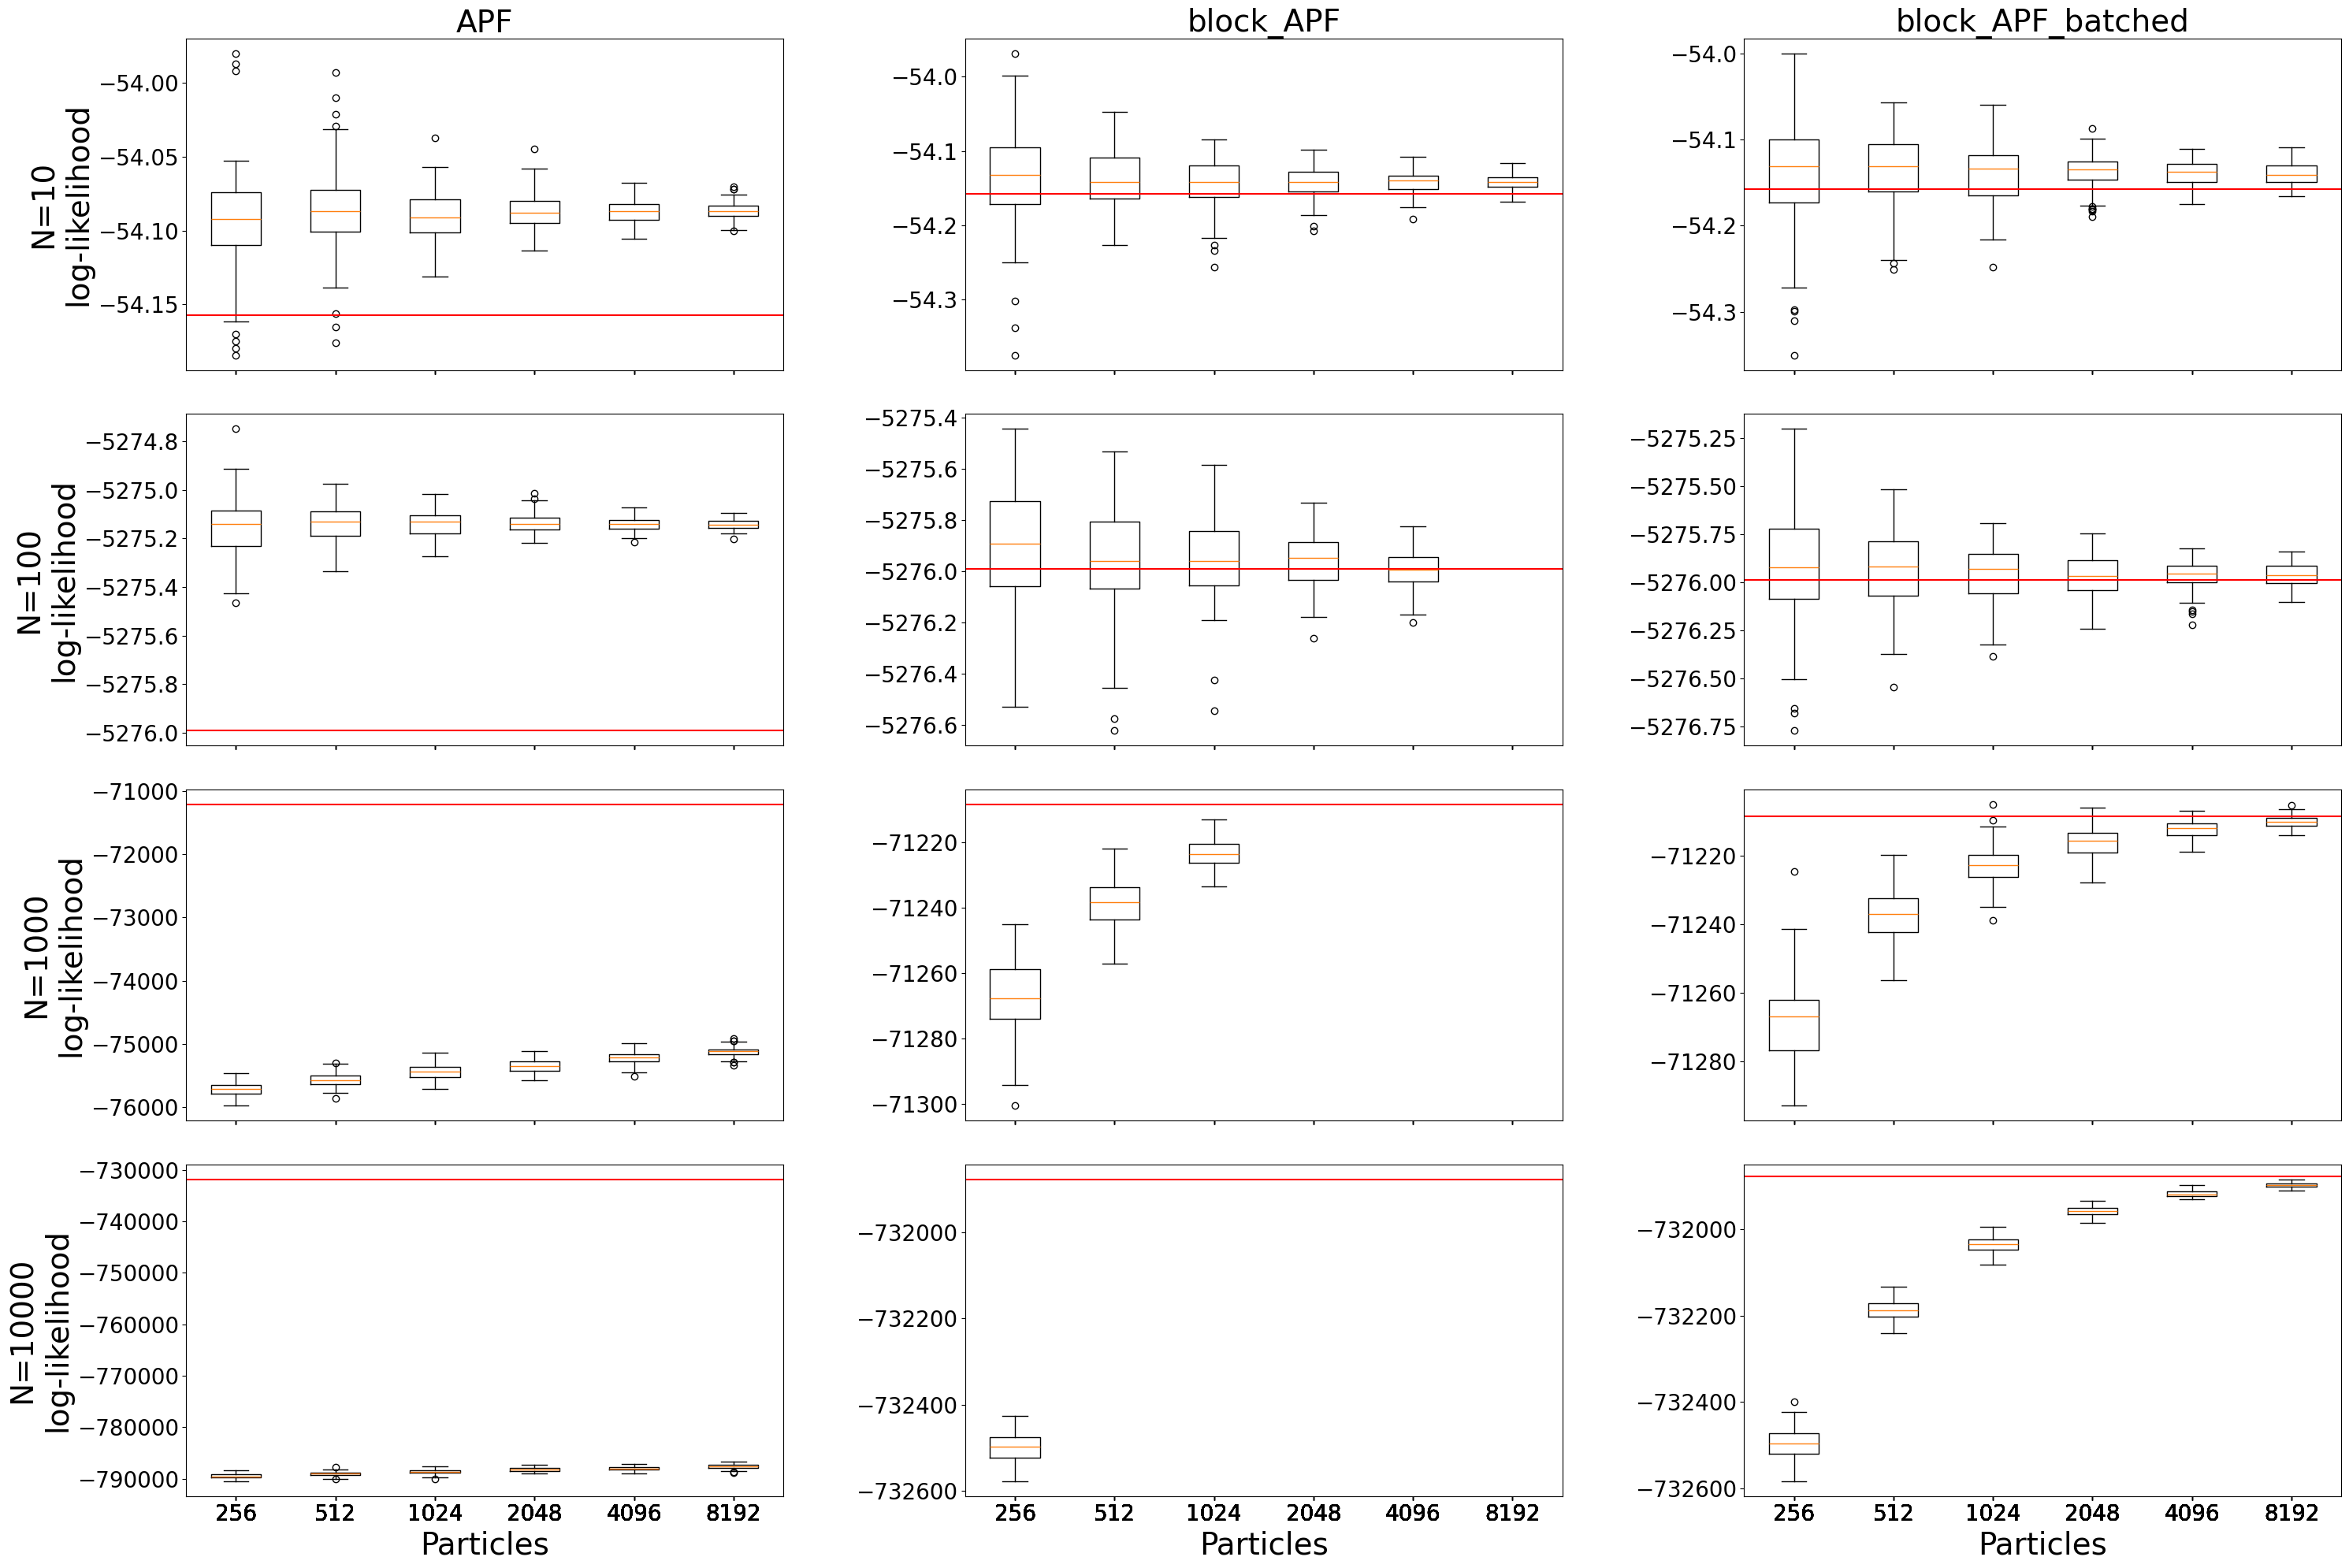

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(30, 20), dpi=100, sharex=True)

for i_N in range(4):

	N = N_list[i_N]

	counter = 0
	for alg in list(boxplot[N].keys())[2:]:

		ax[i_N,counter].boxplot(boxplot[N][alg], labels = P_list)
		ax[i_N,counter].axhline(y=boxplot[N]["CAL"], color = "red")

		if counter ==0:
			ax[i_N,counter].set_ylabel("N="+str(N)+"\n"+"log-likelihood")

		if i_N==3:
			ax[i_N,counter].set_xlabel("Particles")
		
		if i_N==0:
			ax[i_N,counter].set_title(alg)

		counter = counter +1


plt.tight_layout(h_pad=3, w_pad=6)

plt.savefig('Figures/SMC_boxplot.png', format='png', dpi=100)

In [13]:
head = []
head.append("N")
head.append("P")

for element in table_N.keys():
	head.append(element)
	head.append("time(s)")

table = []
table.append(head)

N_list = [10, 100, 1000, 10000]
P_list = [256, 512, 1024, 2048, 4096, 8192]

for N in N_list:

	with open("Data/Likelihood/Output/ju_SIS/"+str(N)+"/likelihood_ju_SIS_"+str(N)+".pkl", 'rb') as file:
		table_N = pkl.load(file)

	for P in P_list:

		row = []

		row.append(N)
		row.append(P)
		
		for alg in table_N.keys():

			if alg=="CAL" or alg=="CAL_compiled":
				if P==256:
					row.append(str(np.round(table_N[alg]["log_like"], 2)))
					row.append(str(np.round(table_N[alg]["comp_time"], 3)))

				else:
					row.append("")
					row.append("")

			else:
				
				if (P in table_N[alg].keys()):

					if table_N[alg][P]["log_like"]!='Out of memory':
						log_like = np.concatenate(table_N[alg][P]["log_like"], axis = 0)
						row.append(str(np.round(np.mean(log_like), 2))+"("+str(np.round(np.std(log_like), 2))+")")
						row.append(str(np.round(np.mean(table_N[alg][P]["comp_time"]), 2)))

					else:
						row.append("Out of memory")
						row.append("")

				else:
					row.append("Out of memory")
					row.append("")

		table.append(row)
			
				
			
print(tabulate(table))

-----  ----  ----------  -------  ------------  -------  ------------------  -------  ----------------  -------  -----------------  -------
N      P     CAL         time(s)  CAL_compiled  time(s)  APF                 time(s)  block_APF         time(s)  block_APF_batched  time(s)
10     256   -67.13      1.393    -67.13        0.001    -67.01(0.03)        0.14     -67.09(0.06)      0.14     -67.1(0.07)        2.12
10     512                                               -67.01(0.02)        0.14     -67.1(0.04)       0.15     -67.11(0.04)       2.12
10     1024                                              -67.01(0.02)        0.14     -67.11(0.03)      0.15     -67.1(0.03)        2.17
10     2048                                              -67.01(0.01)        0.14     -67.1(0.02)       0.15     -67.1(0.02)        2.26
10     4096                                              -67.01(0.01)        0.14     -67.1(0.02)       0.18     -67.1(0.02)        2.25
10     8192                        

In [14]:
print(tabulate(table, tablefmt="latex_raw"))

\begin{tabular}{llllllllllll}
\hline
 N     & P    & CAL        & time(s) & CAL_compiled & time(s) & APF                & time(s) & block_APF        & time(s) & block_APF_batched & time(s) \\
 10    & 256  & -67.13     & 1.393   & -67.13       & 0.001   & -67.01(0.03)       & 0.14    & -67.09(0.06)     & 0.14    & -67.1(0.07)       & 2.12    \\
 10    & 512  &            &         &              &         & -67.01(0.02)       & 0.14    & -67.1(0.04)      & 0.15    & -67.11(0.04)      & 2.12    \\
 10    & 1024 &            &         &              &         & -67.01(0.02)       & 0.14    & -67.11(0.03)     & 0.15    & -67.1(0.03)       & 2.17    \\
 10    & 2048 &            &         &              &         & -67.01(0.01)       & 0.14    & -67.1(0.02)      & 0.15    & -67.1(0.02)       & 2.26    \\
 10    & 4096 &            &         &              &         & -67.01(0.01)       & 0.14    & -67.1(0.02)      & 0.18    & -67.1(0.02)       & 2.25    \\
 10    & 8192 &            &     

In [15]:
boxplot = {}

N_list = [10, 100, 1000, 10000]
P_list = [256, 512, 1024, 2048, 4096, 8192]

for N in N_list:

	boxplot[N] = {}

	with open("Data/Likelihood/Output/ju_SIS/"+str(N)+"/likelihood_ju_SIS_"+str(N)+".pkl", 'rb') as file:
		table_N = pkl.load(file)

	for alg in table_N.keys():

		if alg=="CAL" or alg=="CAL_compiled":
			boxplot[N][alg] = table_N[alg]["log_like"]

		else:
			boxplot[N][alg] = []
			for P in P_list:

				if (P in table_N[alg].keys()):
					if table_N[alg][P]["log_like"]!='Out of memory':
						boxplot[N][alg].append(np.concatenate(table_N[alg][P]["log_like"], axis = 0))
					else:
						boxplot[N][alg].append(np.nan)
				else:
					boxplot[N][alg].append(np.nan)

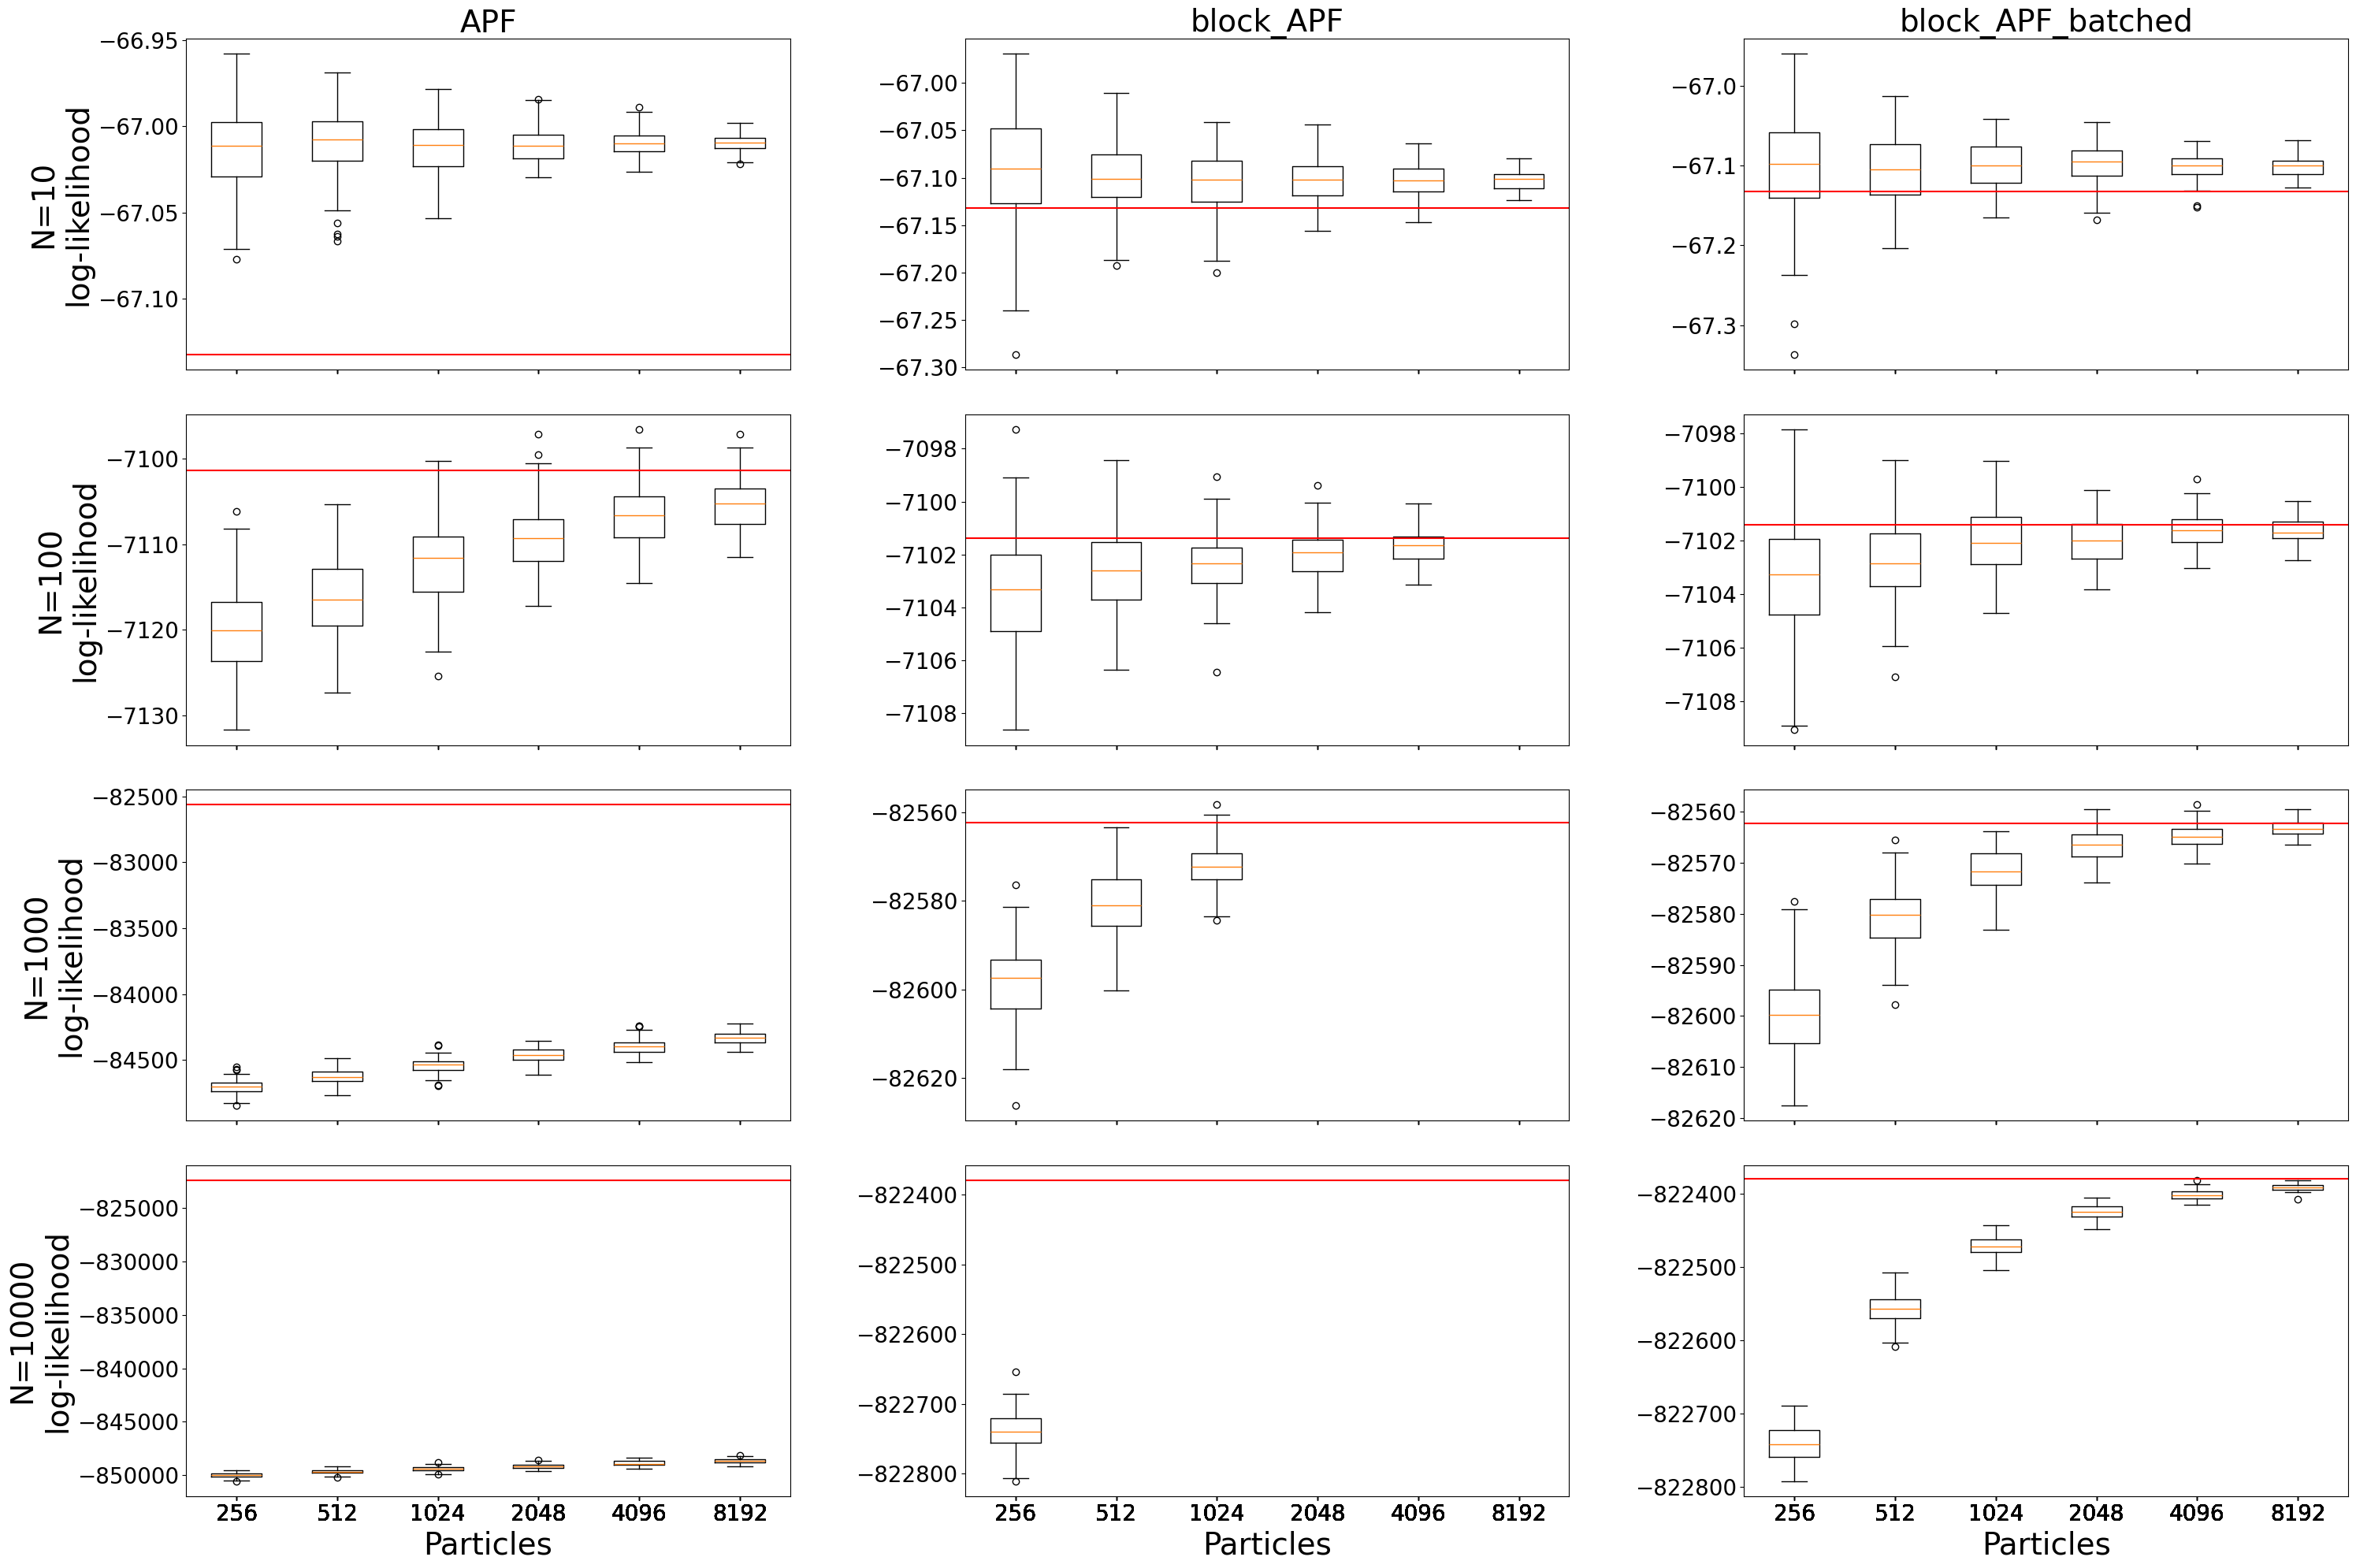

In [16]:
fig, ax = plt.subplots(4, 3, figsize=(30, 20), dpi=100, sharex=True)

for i_N in range(4):

	N = N_list[i_N]

	counter = 0
	for alg in list(boxplot[N].keys())[2:]:

		ax[i_N,counter].boxplot(boxplot[N][alg], labels = P_list)
		ax[i_N,counter].axhline(y=boxplot[N]["CAL"], color = "red")

		if counter ==0:
			ax[i_N,counter].set_ylabel("N="+str(N)+"\n"+"log-likelihood")

		if i_N==3:
			ax[i_N,counter].set_xlabel("Particles")

		if i_N==0:
			ax[i_N,counter].set_title(alg)

		counter = counter +1


plt.tight_layout(h_pad=3, w_pad=6)

plt.savefig('Figures/SMC_boxplot_ju.png', format='png', dpi=100)


# FM data

In [22]:
input_path  = "Data/FM/"

output_path = "Data/FM/HMC/"

name_simulation = "FM_HMC_inference"

# Enable JIT compilation
tf.config.optimizer.set_jit(True)

########################################
# Load parameters, covariates and locations

local_autorities_covariates  = tf.convert_to_tensor(np.load(input_path+"local_autorities_covariates.npy"), dtype = tf.float32)
farms_covariates = tf.convert_to_tensor(np.load(input_path+"farms_covariates.npy"), dtype = tf.float32)
Y = tf.convert_to_tensor(np.load(input_path+"cut_Y_FM.npy"), dtype = tf.float32)

communities = farms_covariates[:,-1:]
farms_covariates = farms_covariates[:,:2]

SIR = FM_SIR(local_autorities_covariates, communities, farms_covariates)

learning_parameters = {
			"log_tau":1,
			"log_beta":1, "b_S":2, "b_I":2, "log_phi":1,	
			"log_gamma":1,
			"log_rho":1, "log_psi":1,
			"log_epsilon":1,
			"logit_prob_I_testing":1}

list_best_param = []
list_best_loss = []

best_initial = []

for test in range(10):
	temp_output_path = input_path+"Output_"+str(test)+"/"
	loss_file_name       = "FM_loss.npy"

	loss       = np.load(temp_output_path+loss_file_name,       allow_pickle=False)
	best_index = np.argmin( np.where(np.isnan(loss[:,-1]), 100, loss[:,-1]))

	list_best_loss.append(loss[best_index,-1])

	dict_best_param = {}

	for i in range(int(len(learning_parameters.keys())/2)):
		for j in range(2):

			key = list(learning_parameters.keys())[2*i+j]

			optim_parameters_file_name = "FM_parameters_"+key+".npy"
			optim_parameters = np.load(temp_output_path+optim_parameters_file_name)

			dict_best_param[key] = optim_parameters[best_index,-1,:]

	list_best_param.append(dict_best_param)

best_optim = np.argmin(np.stack(list_best_loss))

best_parameters = list_best_param[best_optim]

parameters_tensor = best_parameters
parameters_vector_HMC = tf.convert_to_tensor([parameters_tensor["log_tau"][0],
					      parameters_tensor["log_beta"][0],
					      parameters_tensor["b_S"][0], parameters_tensor["b_S"][1],
					      parameters_tensor["b_I"][0], parameters_tensor["b_I"][1],
                                              parameters_tensor["log_phi"][0],
                               		      parameters_tensor["log_gamma"][0],
                               		      parameters_tensor["log_rho"][0],
                               		      parameters_tensor["log_psi"][0],
                               		      parameters_tensor["log_epsilon"][0],
					      parameters_tensor["logit_prob_I_testing"][0]], 
					      dtype = tf.float32)

In [5]:
input_path  = "Data/FM/rerun/"

name_simulation = "FM_inference_next2"

learning_parameters = {
			"log_tau":1,
			"log_beta":1, "b_S":2, "b_I":2, "log_phi":1,	
			"log_gamma":1,
			"log_rho":1, "log_psi":1,
			"log_epsilon":1,
			"logit_prob_I_testing":1}

list_best_param = []
list_best_loss = []

best_initial = []

loss_file_name       = "FM_inference_next2_loss.npy"

loss       = np.load(input_path+loss_file_name,       allow_pickle=False)

dict_best_param = {}

for key in learning_parameters.keys():

	optim_parameters_file_name = input_path+name_simulation+"_parameters_"+key+".npy"
	optim_parameters = np.load(optim_parameters_file_name)

	dict_best_param[key] = optim_parameters

In [6]:
params_next2 = {}
for key in learning_parameters.keys():
	params_next2[key] = np.concatenate(dict_best_param[key][np.where(np.all(loss!=0, axis = 1))[0],...], axis =0)[-1]

In [7]:
best_parameters = {key:tf.convert_to_tensor(best_parameters[key], tf.float32) for key in best_parameters.keys()}

Pi, Mu, Log_likelihood = CAL(SIR, best_parameters, Y)
Log_likelihood

2025-12-12 15:13:06.855670: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(), dtype=float32, numpy=-17947.27>

In [8]:
params_next2 = {key:tf.convert_to_tensor(params_next2[key], tf.float32) for key in best_parameters.keys()}

Pi, Mu, Log_likelihood = CAL(SIR, params_next2, Y)
Log_likelihood

<tf.Tensor: shape=(), dtype=float32, numpy=-17946.734>

In [9]:
parameters_HMC = {}

cum_learning_param = 0
for key in params_next2.keys():

	parameters_HMC[key] = np.load(output_path[:-1]+"_prior/FM_HMC_inference_informative025_posterior.npy")[np.linspace(10000, 60000, 10000).astype(int), cum_learning_param:(cum_learning_param + learning_parameters[key])]

	cum_learning_param = cum_learning_param + learning_parameters[key]

In [10]:
from tabulate import tabulate

In [11]:


table = []

head  = []
head.append("")

row_1 = []
row_1.append("Mean")

row_2 = []
row_2.append("95\% CI")

for key in params_next2.keys():

	if parameters_HMC[key].shape[1]>1:
		head.append(key)
		head.append(key)

		row_1.append(str(np.round(np.mean(parameters_HMC[key][:,0], axis = 0), 2)))
		row_2.append(str(np.round(np.quantile(parameters_HMC[key][:,0], (0.025, 0.975)), 2)))
		
		row_1.append(str(np.round(np.mean(parameters_HMC[key][:,1], axis = 0), 2)))
		row_2.append(str(np.round(np.quantile(parameters_HMC[key][:,1], (0.025, 0.975)), 2)))

	else:
		head.append(key)
		row_1.append(str(np.round(np.mean(parameters_HMC[key], axis = 0)[0], 2)))
		row_2.append(str(np.round(np.quantile(parameters_HMC[key], (0.025, 0.975)), 2)))

table.append(head)
table.append(row_1)
table.append(row_2)	
print(tabulate(table))

-------  ---------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -------------  -----------  ---------------  --------------------
         log_tau          log_beta     b_S          b_S          b_I          b_I          log_phi      log_gamma    log_rho        log_psi      log_epsilon      logit_prob_I_testing
Mean     -12.52           4.83         0.37         0.11         0.23         0.09         3.36         3.0          12.52          1.25         -12.83           0.67
95\% CI  [-13.   -11.97]  [4.49 5.14]  [0.35 0.4 ]  [0.1  0.13]  [0.18 0.3 ]  [0.05 0.12]  [3.32 3.4 ]  [2.47 3.49]  [12.08 12.99]  [0.92 1.44]  [-13.14 -12.54]  [0.51 0.85]
-------  ---------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -------------  -----------  ---------------  --------------------


In [12]:
print(tabulate(table, tablefmt="latex_raw"))

\begin{tabular}{lllllllllllll}
\hline
         & log_tau         & log_beta    & b_S         & b_S         & b_I         & b_I         & log_phi     & log_gamma   & log_rho       & log_psi     & log_epsilon     & logit_prob_I_testing \\
 Mean    & -12.52          & 4.83        & 0.37        & 0.11        & 0.23        & 0.09        & 3.36        & 3.0         & 12.52         & 1.25        & -12.83          & 0.67                 \\
 95\% CI & [-13.   -11.97] & [4.49 5.14] & [0.35 0.4 ] & [0.1  0.13] & [0.18 0.3 ] & [0.05 0.12] & [3.32 3.4 ] & [2.47 3.49] & [12.08 12.99] & [0.92 1.44] & [-13.14 -12.54] & [0.51 0.85]          \\
\hline
\end{tabular}


In [13]:
# for i in range(12):
	
# 	plt.plot(np.load(output_path[:-1]+"_prior/FM_HMC_inference_informative025_posterior.npy")[np.linspace(10000, 60000, 10000).astype(int),i])
# 	plt.axhline(y=np.concatenate(list(params_next2.values()))[i])

# 	plt.show()

In [14]:
import seaborn as sns

def f_HMC(parameters, x, y):
    
    return tf.math.exp(x*np.mean(parameters["b_S"][:,0]) + y*np.mean(parameters["b_S"][:,1]) )

def h_HMC(parameters, x, y):
    
    return tf.math.exp(x*np.mean(parameters["b_I"][:,0]) + y*np.mean(parameters["b_I"][:,1]) )

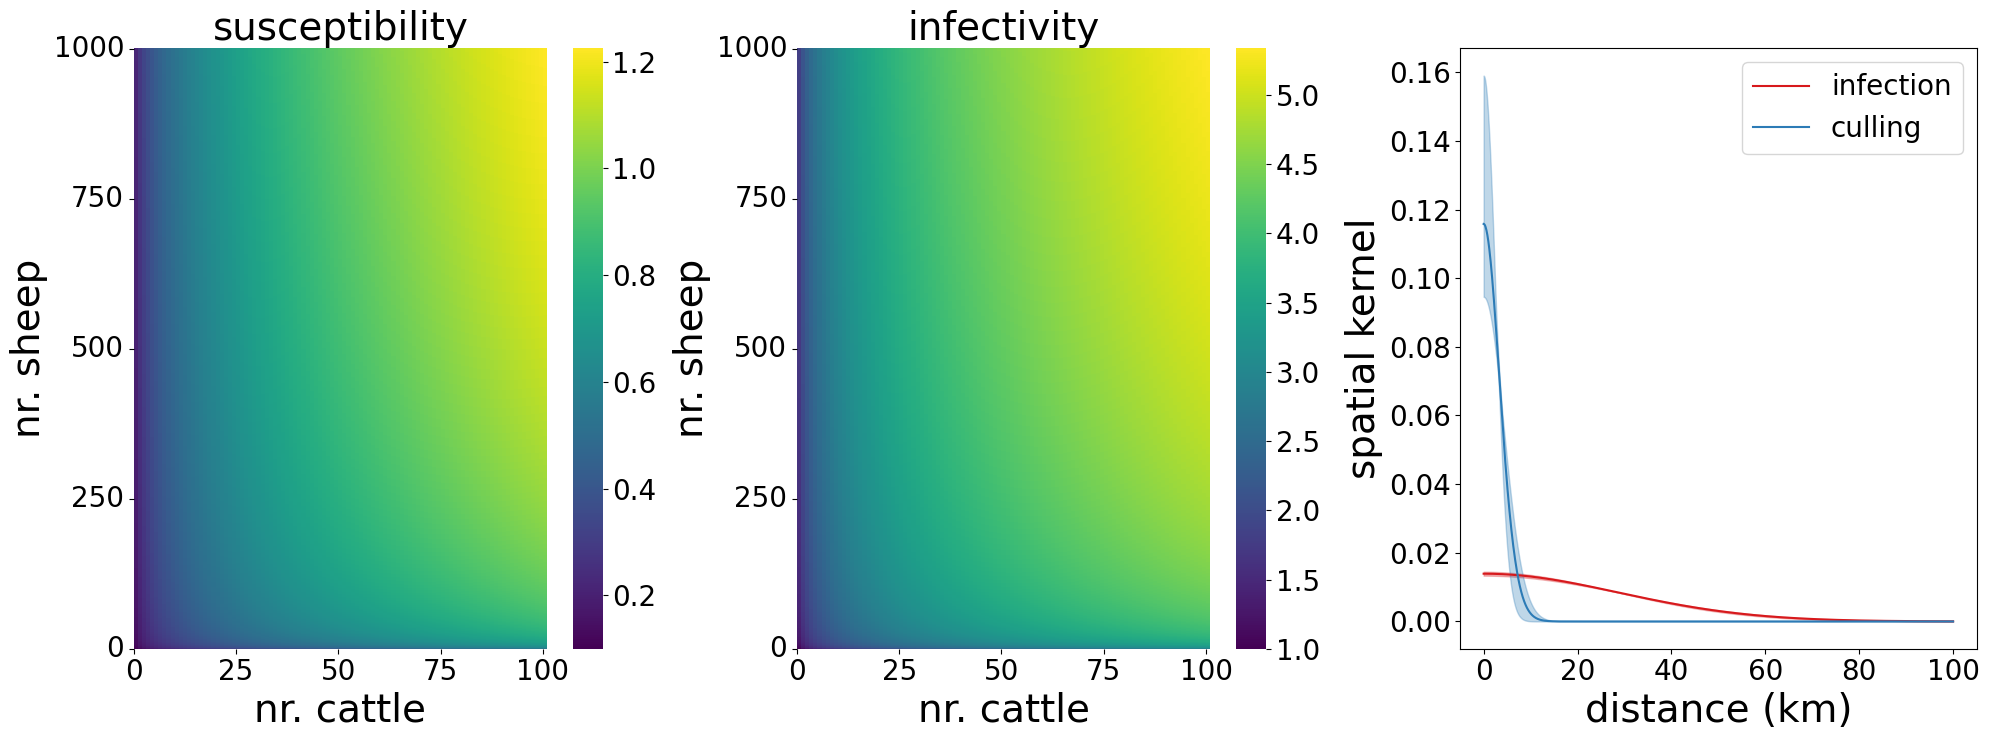

In [24]:
xx = np.linspace(0, 100, 101)
yy = np.linspace(0, 1000, 1001)
Xx, Yy = np.meshgrid(np.log(1+xx), np.log(1+yy))
Z1 = f_HMC(parameters_HMC, Xx, Yy)/10
Z2 = h_HMC(parameters_HMC, Xx, Yy)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7.5))

sns.heatmap(Z1, ax=ax1, cmap='viridis') #, origin = "lower")
ax1.set_title('susceptibility')
ax1.set_xlabel('nr. cattle')  
ax1.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax1.set_xticks(np.linspace(0, len(xx)-1, num=5))  # 5 evenly spaced ticks
ax1.set_xticklabels(np.linspace(xx.min(), xx.max(), num=5).astype(int), rotation=0)
ax1.set_yticks(np.linspace(0, len(yy)-1, num=5)[::-1])  # 5 evenly spaced ticks
ax1.set_yticklabels(np.linspace(yy.min(), yy.max(), num=5)[::-1].astype(int))

sns.heatmap(Z2, ax=ax2, cmap='viridis') #, origin = "lower")
ax2.set_title('infectivity')
ax2.set_xlabel('nr. cattle')  
ax2.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax2.set_xticks(np.linspace(0, len(xx)-1, num=5))  # 5 evenly spaced ticks
ax2.set_xticklabels(np.linspace(xx.min(), xx.max(), num=5).astype(int), rotation=0)
ax2.set_yticks(np.linspace(0, len(yy)-1, num=5))  # 5 evenly spaced ticks
ax2.set_yticklabels(np.linspace(yy.min(), yy.max(), num=5).astype(int))

ax1.invert_yaxis()
ax2.invert_yaxis()

spatial_inf = tfp.distributions.Normal(loc = 0, scale = tf.math.exp(parameters_HMC["log_phi"])).prob(np.linspace(0, 100, 1000))
ax3.plot(np.linspace(0, 100, 1000), tf.reduce_mean(spatial_inf, axis = 0), color = "#d7191c", label = "infection")
ax3.fill_between(np.linspace(0, 100, 1000), np.quantile(spatial_inf, (0.025, 0.975), axis = 0)[0,:], np.quantile(spatial_inf, (0.025, 0.975), axis = 0)[1,:], color = "#d7191c", alpha = 0.3)
# ax3.set_xticks(np.linspace(0, 20, num=5))
ax3.set_xlabel("distance (km)")
ax3.set_ylabel("spatial kernel")
fig.tight_layout()

spatial_cull = tfp.distributions.Normal(loc = 0, scale = tf.math.exp(parameters_HMC["log_psi"])).prob(np.linspace(0, 100, 1000))
ax3.plot(np.linspace(0, 100, 1000), tf.reduce_mean(spatial_cull, axis = 0), color = "#2c7bb6", label = "culling")
ax3.fill_between(np.linspace(0, 100, 1000), np.quantile(spatial_cull, (0.025, 0.975), axis = 0)[0,:], np.quantile(spatial_cull, (0.025, 0.975), axis = 0)[1,:], color = "#2c7bb6", alpha = 0.3)
# ax3.set_xticks(np.linspace(0, 20, num=5))
ax3.set_xlabel("distance (km)")
ax3.set_ylabel("spatial kernel")
ax3.legend()


fig.tight_layout()

plt.savefig('Figures/FM_susc_inf_spat_HMC.png', format='png', dpi=300)

In [25]:
parameters_HMC_tensor = {}

for key in parameters_HMC.keys():

	parameters_HMC_tensor[key] = tf.reduce_mean(tf.convert_to_tensor(parameters_HMC[key], tf.float32), axis = 0)

In [26]:
Pi, Mu, Log_likelihood = CAL(SIR, parameters_HMC_tensor, Y)

In [27]:
import pandas as pd
import geopandas as gp

geo_farms_within_valid = gp.read_file("Data/FM/geopandas/geo_farms_within_valid.geojson", driver="GeoJSON")
geo_states = gp.read_file("Data/FM/geopandas/geo_states.geojson", driver="GeoJSON")
geo_counties_valid = gp.read_file("Data/FM/geopandas/geo_counties_valid.geojson", driver="GeoJSON")

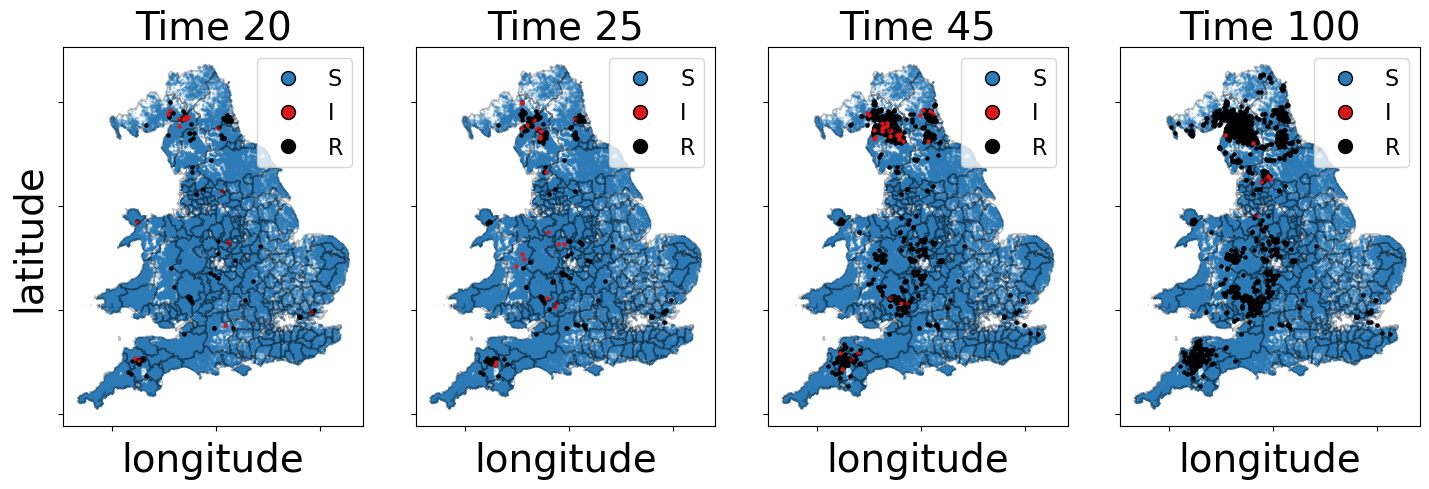

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

time_steps = [20, 25, 45, 100]

for i in range(4):

	t = time_steps[i]

	if i==0:
		ax[i].set_ylabel('latitude')

	ax[i].set_xlabel('longitude')

	ax[i].set_xticklabels([])
	ax[i].set_yticklabels([])
	
	ax[i].set_title("Time "+str(t))

	suscep_label = tf.where(tf.math.argmax(Pi, axis = -1)[t,:]==0)[:,0]
	infect_label = tf.where(tf.math.argmax(Pi, axis = -1)[t,:]==1)[:,0]
	remove_label = tf.where(tf.math.argmax(Pi, axis = -1)[t,:]==2)[:,0]

	geo_suscep = geo_farms_within_valid.loc[suscep_label.numpy()]
	geo_infect = geo_farms_within_valid.loc[infect_label.numpy()]
	geo_remove = geo_farms_within_valid.loc[remove_label.numpy()]

	ax[i].scatter(np.array(geo_suscep.get_coordinates()["x"]), np.array(geo_suscep.get_coordinates()["y"]), s=0.1, alpha = 0.5, color = "#2c7bb6")
	ax[i].scatter(np.array(geo_remove.get_coordinates()["x"]), np.array(geo_remove.get_coordinates()["y"]), s=5.0, color = "black")
	ax[i].scatter(np.array(geo_infect.get_coordinates()["x"]), np.array(geo_infect.get_coordinates()["y"]), s=5.0, color = "#d7191c")
	geo_counties_valid.plot(ax = ax[i], color = "none", edgecolor='black', alpha = 0.25)

	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black", markeredgecolor='black', markersize=10, label="R"),
	]

	ax[i].legend(handles=legend_handles, fontsize=16)

plt.subplots_adjust( wspace=-0.75)
plt.tight_layout()
plt.savefig('Figures/FM_spatial_tracking_HMC.png', format='png', dpi=300, bbox_inches='tight')

# FM overdispersion

In [58]:
import pickle

In [59]:
name_simulation = "FM_SMC_ovd_"
input_path  = "Data/FM/"
output_path = "Data/FM/SMC/"

data_list = []
max_list = []
argmax_list = []
for i in range(9):
	with open(output_path+name_simulation+str(i)+"_loglike.pkl", "rb") as f:
		data = pickle.load(f)

	data_list.append(np.stack(data))

	argmax_list.append(np.argmax(np.stack(data)))
	max_list.append(np.max(np.stack(data)))

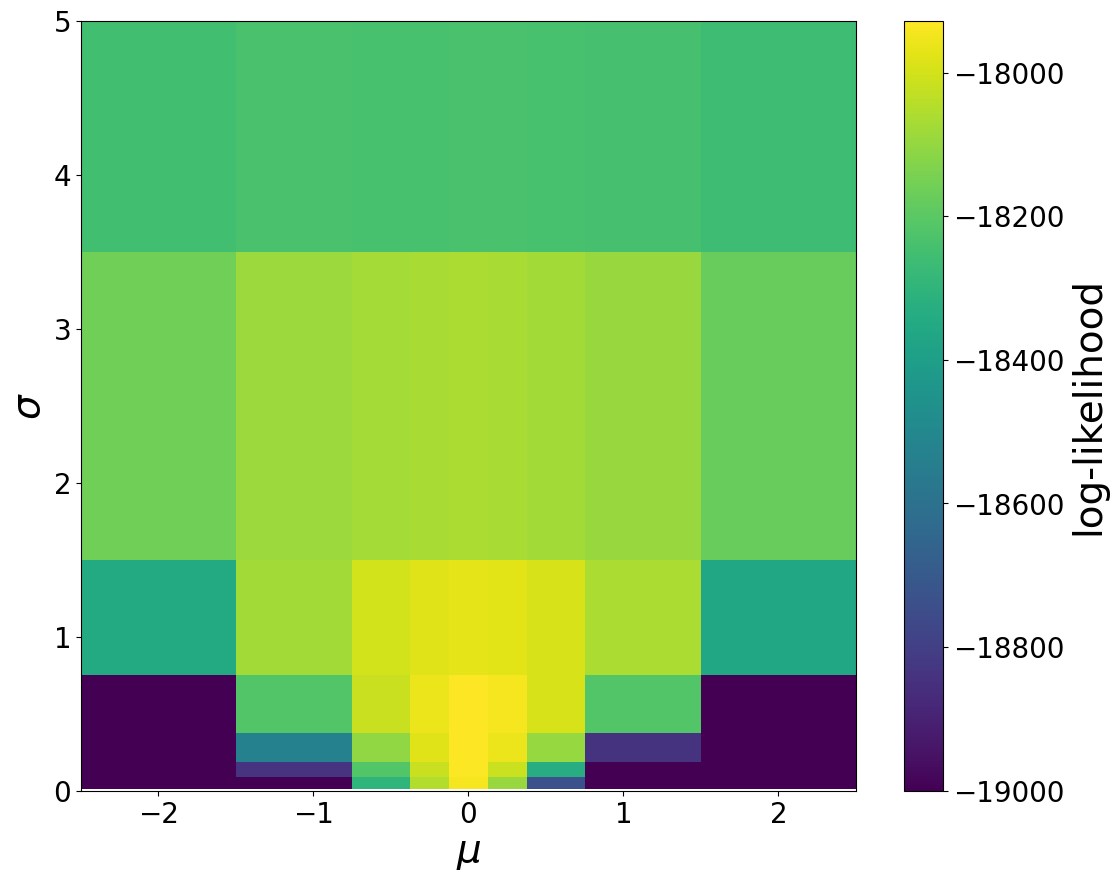

In [60]:
# grids
grid_mean = np.array([-2, -1, -0.5, -0.25, 0.0, 0.25, 0.5, 1, 2])
grid_std  = np.array([0.05, 0.125, 0.25, 0.5, 1, 2, 5])

# Z from your data
Z = np.concatenate(data_list, axis = 1)

# make 2D coordinate grids
X, Y = np.meshgrid(grid_mean, grid_std)

fig, ax = plt.subplots(1, 1, figsize=(12.5, 10), dpi=100)

heat = ax.pcolormesh(
    X, Y, Z,
    vmin=-19000,
    vmax=Z.max(),
    cmap="viridis",
    shading="auto"   # avoids warnings about dimensions
)

ax.set_ylim((0, 5))
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")

# colorbar
cbar = fig.colorbar(heat, ax=ax)
cbar.set_label("log-likelihood")


plt.savefig('Figures/ovd_grid.png', format='png', dpi=100)

In [61]:
grid_mean[np.argmax(np.stack(max_list))], grid_std[argmax_list[np.argmax(np.stack(max_list))]], np.max(Z)

(0.0, 0.25, -17927.818)

In [67]:
name_simulation = "FM_SMC_ovd"
input_path  = "Data/FM/"
output_path = "Data/FM/SMC_ovd/"

data_list = []
for i in range(9):
	with open(output_path+name_simulation+str(i)+"_output_SMC_ovd.pkl", "rb") as f:
		data = pickle.load(f)

	data_list.append(data)

In [75]:
data_list[0]["shared"]["time"][0]/60

6.89019414583842

In [76]:
data_list[3]["local"]["time"][0]/60

42.031286132335666

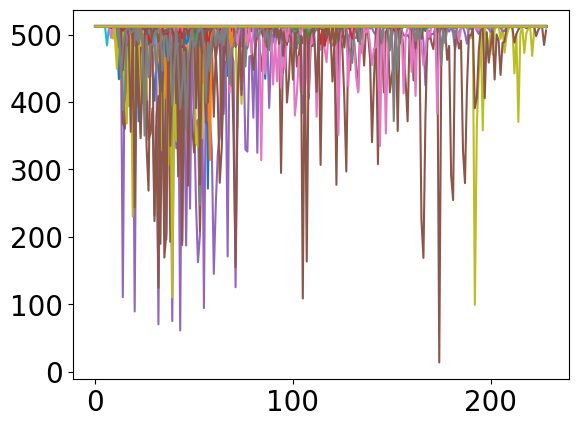

In [60]:
plt.plot(np.transpose(np.load(output_path+name_simulation+"comm_paramESS.npy")))

In [44]:
parameters_vector_HMC

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([ -9.488292  ,   4.8994093 ,   0.37336087,   0.11110237,
         0.2259851 ,   0.0791605 ,   3.3599951 ,   2.8652446 ,
        12.421624  ,   1.3454381 , -12.753486  ,   0.6929044 ],
      dtype=float32)>

In [41]:
learning_parameters.keys()

dict_keys(['log_tau', 'log_beta', 'b_S', 'b_I', 'log_phi', 'log_gamma', 'log_rho', 'log_psi', 'log_epsilon', 'logit_prob_I_testing'])

In [ ]:
for i in range(np.shape(list(learning_parameters.keys()))[0])

	key = list(learning_parameters.keys())[i]

In [37]:
np.load(output_path+name_simulation+"_posterior.npy")

NameError: name 'name_simulation' is not defined

In [6]:
P_list = [512, 1024, 2048, 4096, 8192]

head = []
head.append("N=?")
for P in P_list:

	head.append("P="+str(P))

table = []
table.append(head)

for alg in list(table_N.keys())[2:]:
	row = []
	row.append(alg)

	comp_cost = []
	for P in P_list:

		if (P in table_N[alg].keys()):

			if table_N[alg][P]["log_like"]!='Out of memory':
				log_like = np.concatenate(table_N[alg][P]["log_like"], axis = 0)

				row.append(str(np.round(np.mean(log_like), 2))+"("+str(np.round(np.std(log_like), 2))+")")
				comp_cost.append(table_N[alg][P]["comp_time"])
			else:
				row.append("Out of memory")

		else:
			row.append("Out of memory")

	row.append(str(np.round(np.mean(np.concatenate(comp_cost, axis = 0)), 2))+"s")

	table.append(row)

for alg in list(table_N.keys())[:2]:
	row = []
	row.append(alg)

	row.append("")
	row.append("")
	row.append("")
	row.append("")

	row.append(str(np.round(table_N[alg]["log_like"], 2)))
	row.append(str(np.round(table_N[alg]["comp_time"], 3))+"s")

	table.append(row)


print(tabulate(table))

-----------------  ---------------  -----------------  ----------------  -----------------  ---------------  ------
N=?                P=512            P=1024             P=2048            P=4096             P=8192
APF                -75573.42(95.3)  -75443.16(114.76)  -75347.03(96.99)  -75222.62(100.85)  -75124.21(78.4)  2.94s
block_APF          -71238.36(7.07)  -71223.33(4.8)     Out of memory     Out of memory      Out of memory    3.48s
block_APF_batched  -71237.22(7.12)  -71222.89(5.54)    -71216.06(4.01)   -71212.16(2.57)    -71209.94(1.82)  69.29s
CAL                                                                                         -71208.38        1.915s
CAL_compiled                                                                                -71208.38        0.001s
-----------------  ---------------  -----------------  ----------------  -----------------  ---------------  ------


In [28]:
np.mean(table_N[alg][1024]["comp_time"])

192.2767291355133